In [1]:
import glob
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy.stats import ttest_ind

In [2]:
def mode2name(mode):
    if mode == 1:
        return "Background Color"
    elif mode == 2:
        return "Letter"
    elif mode == 3:
        return "Object Color"

In [3]:
base_location = '/mnt/HDD/CounterVision/SyntheticImages'
config_choice = 'run'

if config_choice == 'test':
    mode_list = [1, 2]
    n_list = [10000, 15000]
    p_list = [0.95]
    trial_list = [0,1,2,3,4]
elif config_choice == 'run':
    mode_list = [1, 2, 3]
    n_list = [5000, 10000, 15000, 20000]
    p_list = [0.5, 0.8, 0.85, 0.9, 0.95, 1.0]
    trial_list = [0,1,2,3,4]

def compare(model_new, model_ref):

    out = []
    for mode in mode_list:
        for n in n_list:
            for p in p_list:
                
                train_new = []
                neutral_new = []
                
                train_ref = []
                neutral_ref = []
                
                for trial in trial_list:

                    save_location = '{}/mode={}/n={}/p={}/trial{}/'.format(base_location, mode, n, p, trial)
                    os.chdir(save_location)

                    for file in glob.glob('*.json'):
                        data = json.load(open(file, 'r'))
                        
                        if file == model_new:
                            train_new.append(data['train'])
                            neutral_new.append(data['neutral'])
                        elif file == model_ref:
                            train_ref.append(data['train'])
                            neutral_ref.append(data['neutral'])
                
                tn_mean = np.mean(train_new)
                nn_mean = np.mean(neutral_new)
                
                tr_mean = np.mean(train_ref)
                nr_mean = np.mean(neutral_ref)
                
                if len(train_new) > 0 and len(train_ref) > 0:
                    test_train = ttest_ind(train_new, train_ref)[1]
                else:
                    test_train = 1.0
                    
                if len(neutral_new) > 0 and len(neutral_ref) > 0:
                    test_neutral = ttest_ind(neutral_new, neutral_ref)[1]
                else:
                    test_neutral = 1.0
                                    
                out.append([mode, n, p, tn_mean, nn_mean, tr_mean, nr_mean, test_train, test_neutral])
                
    df = pd.DataFrame(out, columns = ['mode', 'n', 'p', 'tn_mean', 'nn_mean', 'tr_mean', 'nr_mean', 'test_train', 'test_neutral'])    
    
    for label_outer, df_outer in df.groupby('mode'):

        fig = plt.figure(figsize=(20, 10))
        fig.subplots_adjust(hspace=0.2, wspace=0.2)

        fig.suptitle('Test Accuracy Comparison: {}'.format(mode2name(label_outer)))
        
        plt.subplot(2, 4, 1)
        for label, df in df_outer.groupby('p'):
            plt.plot(df['n'], df['tr_mean'], label = label)
        plt.title(model_ref)
        plt.xlabel('n')
        plt.ylim(0,1)
        plt.ylabel('Accuracy - Training Distribution')
        plt.legend(title = 'p')

        
        plt.subplot(2, 4, 2)
        for label, df in df_outer.groupby('p'):
            plt.plot(df['n'], df['tn_mean'], label = label)
        plt.title(model_new)
        plt.xlabel('n')
        plt.ylim(0,1)
        
        plt.subplot(2, 4, 3)
        for label, df in df_outer.groupby('p'):
            plt.plot(df['n'], df['tn_mean'] - df['tr_mean'], label = label)
        plt.title('change')
        plt.xlabel('n')
        
        plt.subplot(2, 4, 4)
        for label, df in df_outer.groupby('p'):
            plt.plot(df['n'], df['test_train'], label = label)
        plt.title('t-test p-value of change')
        plt.xlabel('n')
        plt.ylim(0, 1)
        
        plt.subplot(2, 4, 5)
        for label, df in df_outer.groupby('p'):
            plt.plot(df['n'], df['nr_mean'], label = label)
        plt.xlabel('n')
        plt.ylabel('Accuracy - Neutral Distribution')
        plt.ylim(0,1)
        
        plt.subplot(2, 4, 6)
        for label, df in df_outer.groupby('p'):
            plt.plot(df['n'], df['nn_mean'], label = label)
        plt.xlabel('n')
        plt.ylim(0,1)
        
        plt.subplot(2, 4, 7)
        for label, df in df_outer.groupby('p'):
            plt.plot(df['n'], df['nn_mean'] - df['nr_mean'], label = label)
        plt.xlabel('n')
        
        plt.subplot(2, 4, 8)
        for label, df in df_outer.groupby('p'):
            plt.plot(df['n'], df['test_neutral'], label = label)
        plt.xlabel('n')
        plt.ylim(0, 1)
        
        plt.show()
        plt.close()
                    
                            


Baseline:  model_original.json



/home/gregory/anaconda3/envs/countervision/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/gregory/anaconda3/envs/countervision/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


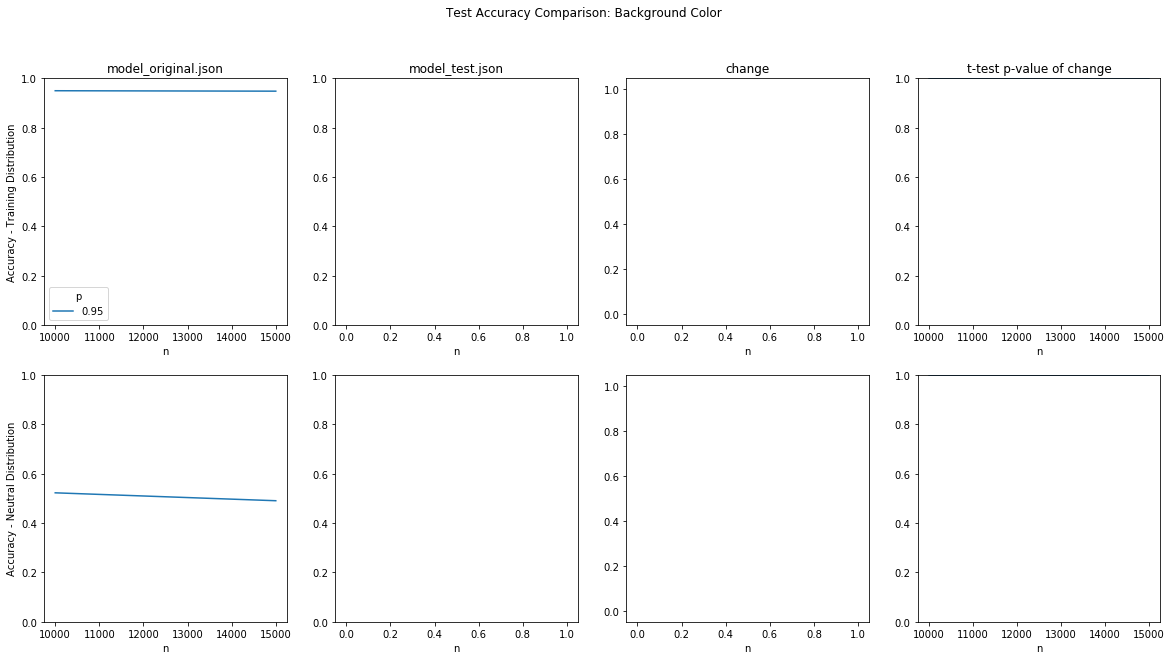

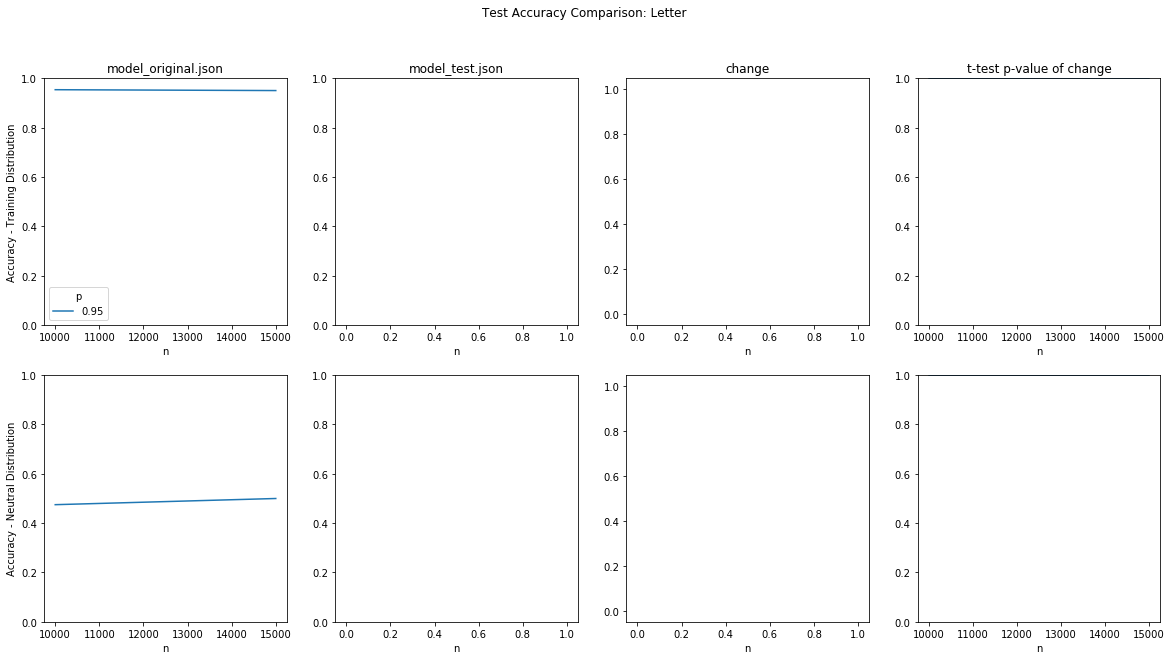


Baseline:  model_augmented.json



/home/gregory/anaconda3/envs/countervision/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/gregory/anaconda3/envs/countervision/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


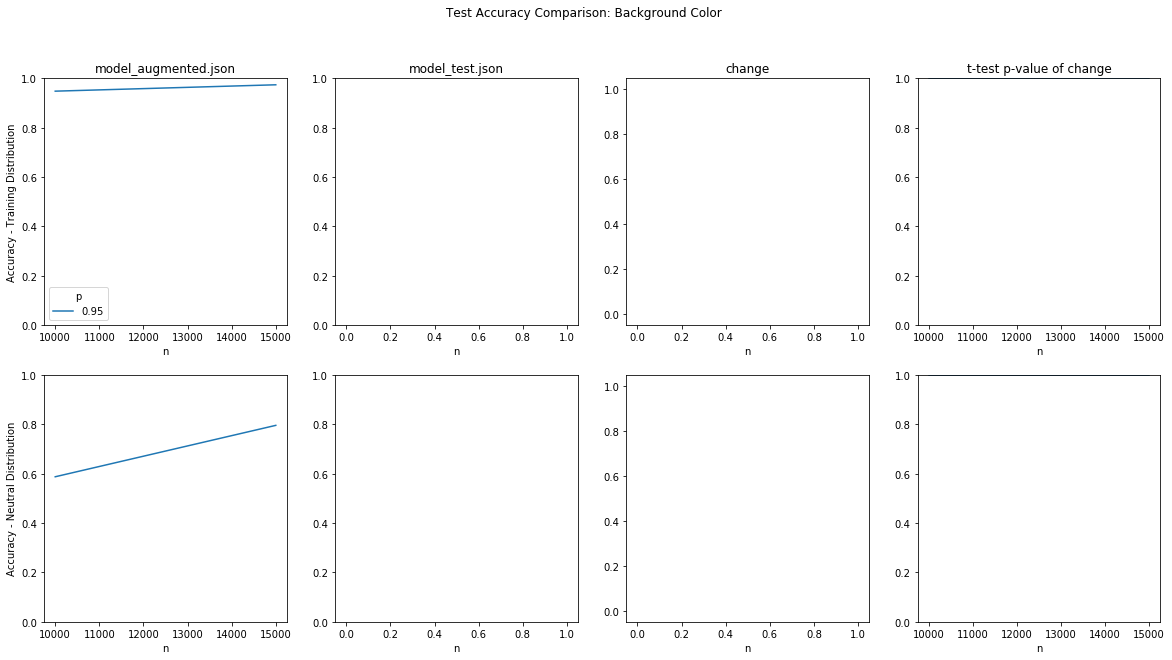

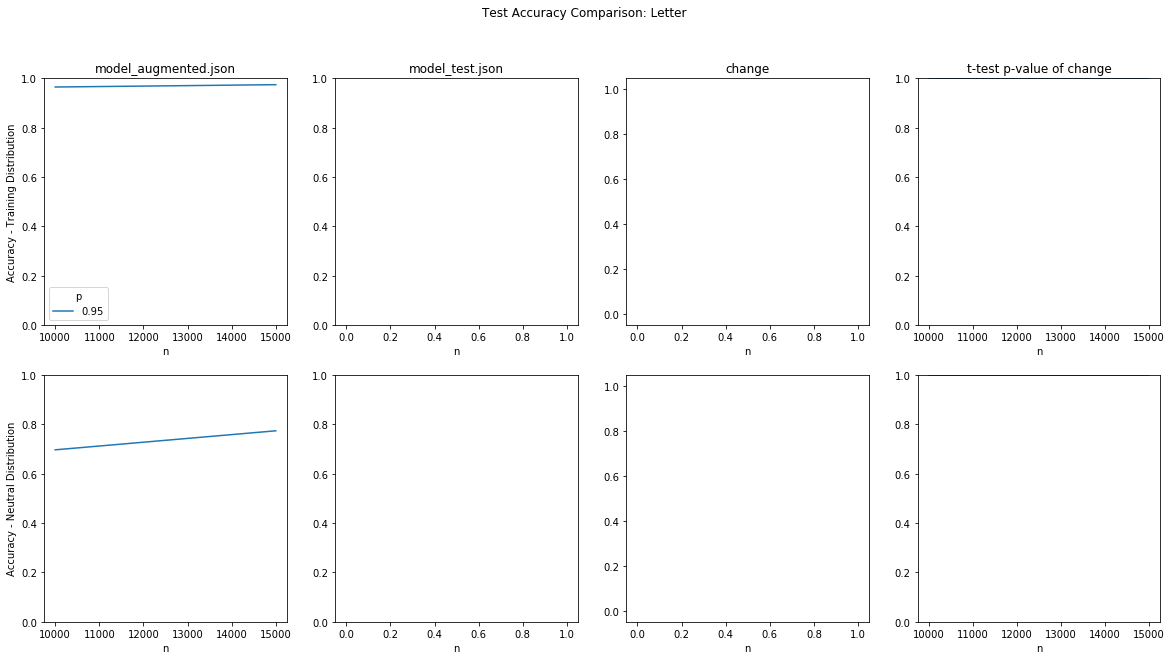

In [4]:
if config_choice == 'test':
    query = 'model_test.json'

    for baseline in ['model_original.json','model_augmented.json']:
        print('')
        print('Baseline: ', baseline)
        print('')

        compare(query, baseline)
        
elif config_choice == 'run':
    print('Evaluating Augmentation')
    compare('model_augmented.json', 'model_original.json')